In [27]:
from dotenv import load_dotenv
import os
import time
import http.client
from langchain_groq import ChatGroq
from langchain_mistralai import ChatMistralAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
import google.generativeai as genai
import requests
from uuid import uuid4
import json
import random

load_dotenv()

True

In [5]:
import time, random
def response_generator():
    response = random.choice(
        [
            "Hello there! How can I assist you today?",
            "Hi, human! Is there anything I can help you with?",
            "Do you need help?",
        ]
    )
    for word in response.split():
        yield word + " "
        time.sleep(0.05)
        
for i in response_generator():
    print(i)

Hello 
there! 
How 
can 
I 
assist 
you 
today? 


### SETTING UP GROUND X CLIENT TO SUPPLY DOCUMENTS

In [4]:
# TESTING GROUNDX FOR CPG RAG
from groundx import GroundX
groundx_client = GroundX(
    api_key=os.getenv("GROUNDX_API_KEY", ""),
)

# LIST ALL EXISTING BUCKERS
buckets = groundx_client.buckets.list()
# LIST ALL EXISTING BUCKERS
groundx_documents = groundx_client.documents.list()
groundx_docs = groundx_documents.dict()["documents"][7]['fileName']

In [59]:
# LIST ALL EXISTING BUCKETS
current_bucket = buckets.dict()["buckets"][0]['bucketId']
print(current_bucket)

13857


In [62]:
# TEST GROUNDX SEARCH FOR DOCUMENTS
groundx_search_query = "How should modifiable lifestyle risk factors like smoking and obesity be addressed in the periodic health examination for cardiovascular disease prevention?"
search_results = groundx_client.search.content(id = current_bucket, query = groundx_search_query, n=5)

In [70]:
groundx_result = search_results.search.text
print(groundx_result)

The following text excerpt is from a section of a document named '%5BCPG%5D+Periodic+Health+Examination_+Screening+for+Cardiovascular+Disease.pdf':

Text excerpt from page number 14, page number 15, and page number 16:
Cardiovascular disease is the leading cause of death in the country today. Several factors contribute to cardiovascular disease, with environmental influences and lifestyle changes being the primary culprits. Cigarette smoking, diabetes mellitus, elevated cholesterol, obesity, and physical inactivity are some identified factors that can lead to cardiovascular death. Early identification and addressing of these factors may reduce the burden of cardiovascular diseases in the country.

Thus, it is important to recognize the significance of screening individuals for cardiovascular diseases. This consensus statement addresses screening for cardiovascular diseases among apparently healthy, asymptomatic adult Filipino individuals. Such individuals are generally considered to ha

### CLEANING AND PREPARING DOCUMENTS FOR EMBEDDING

In [5]:
# FUNCTION TO CLEAN FILE NAME
def clean_fileName(text):
    fileName_split = text.replace("  ", " ").split(".")[0]
    cleaned_file_name = fileName_split.replace("_", "").split(" ")[1:]
    cleaned_docs = "".join(["".join(i[0]) for i in cleaned_file_name if i[0].isupper()])
    return cleaned_docs

print(clean_fileName(groundx_docs))

MAISIH


In [6]:
# FUNCTION TO EXTRACT KEYWORDS FROM SECTION SUMMARY
def extract_keywords(text):
    # Split the text at "Keywords:" to isolate the keyword section
    split_text = text.split("Keywords: ")
    
    # Check if keywords section exists
    if len(split_text) < 2:
        return []
    
    # Split keywords by comma and clean whitespace
    keywords = [kw.strip() for kw in split_text[1].split(",")]
    
    # Return first 8 keywords (or fewer if there aren't enough)
    return keywords[:8]

In [7]:
def split_keep(string, sep):
    """Usage:
    >>> list(split_keep("a.b.c.d", "."))
    ['a.', 'b.', 'c.', 'd']
    """
    start = 0
    while True:
        end = string.find(sep, start) + 1
        if end == 0:
            break
        yield string[start:end]
        start = end
    yield string[start:]

In [8]:
# FUNCTION TO CLEAN TABLE TYPE AND REMOVE UNNECESSARY FIELDS
def clean_tables(table):
    cleaned_table = []
    table_content = list(split_keep(table, "}\n"))[:-1]

    for content in table_content:
        cleaned_content = content.replace("\n", "")
        cleaned_table.append(cleaned_content)

    return "".join(cleaned_table)

In [ ]:
# DATA CHUNKING AND INGESTION TO NOMIC PER DOCUMENT
def chunk_ingest(documents: dict):
    
    # DEFINE LIST TO HOLD CHUNKED DOCUMENTS
    chunks = []
    
    for document in documents:
        # LOAD DOCUMENT FROM JSON URL
        response = requests.get(document["xrayUrl"])
        print(f"LOADING DOCUMENT: {document['fileName']}")
        sample_document = json.loads(response.text)
        
        # PLACEHOLDER FOR CHUNKS\
        chunk_holder = {}
        
        # LOOP OVER SAMPLE DOCUMENTS
        for chunk in sample_document["chunks"]:
            # SKIP CONTENT TYPE WITH FIGURE
            if "figure" in chunk["contentType"]:
                continue

            # CLEAN TABLE CONTENT BEFORE APPENDING
            if "table" in chunk["contentType"]:
                chunk_holder["suggestedText"] = clean_tables(chunk.get("suggestedText", ""))
            elif "paragraph" in chunk["contentType"]:
                chunk_holder["suggestedText"] = chunk.get("suggestedText", "")

            # OBTAIN PAGE NUMBERS AND KEYWORDS
            pageNumbers = chunk.get("pageNumbers", "")
            keywords = extract_keywords(chunk.get("sectionSummary", ""))
            # CONVERT PAGE NUMBERS AND KEYWORDS TO STRING
            if len(pageNumbers) > 1 or len(keywords) > 1:
                pageNumber = ", ".join(["".join(str(num)) for num in pageNumbers])
                keyword = ", ".join(keywords)
            else:
                pageNumber = "".join(["".join(str(num)) for num in pageNumbers])
                keyword = "".join(keywords)
                
            chunk_holder["pageNumbers"] = pageNumber
            chunk_holder["keywords"] = keyword
        
            # ASSEMBLE CHUNK DICTIONARY
            chunk = {
                "id": f"{clean_fileName(document['fileName'])}_{str(uuid4()).replace('-', '_')[10:]}",
                "suggestedText": chunk_holder["suggestedText"],
                "metadata": {
                    "fileName": document["fileName"],
                    "pageNumbers": pageNumber,
                    "keywords": keyword,
                }
            }
        
            # APPEND TO CHUNKS LIST
            chunks.append(chunk)
        
    return chunks     

In [12]:
chunks_with_id = chunk_ingest(groundx_documents.dict()["documents"])
len(chunks_with_id)

LOADING DOCUMENT: [CPG] Periodic Health Examination_ Lifestyle Advice.pdf
LOADING DOCUMENT: [CPG] Diagnosis and Management of Urinary Tract Infection Among Filipino Children and Adults.pdf
LOADING DOCUMENT: [CPG] Periodic Health Examination_ Screening for Cardiovascular Disease.pdf
LOADING DOCUMENT: [CPG] Periodic Health Examination_ Screening for Vision Disorders.pdf
LOADING DOCUMENT: [CPG] Management of Chronic Obstructive Pulmonary Disease.pdf
LOADING DOCUMENT: [CPG] Pathways for the Evaluation and  Management of Patients with Dizziness in Family and Community Practice.pdf
LOADING DOCUMENT: [CPG] Philippine Retinoblastoma Clinical Practice Guidelines.pdf
LOADING DOCUMENT: [CPG] Management of Acute Ischemic Stroke and Intracerebral Hemorrhage 2024.pdf


1277

In [13]:
# FUNCTION TO BREAK CHUNKS INTO DOCUMENTS
def break_chunks(chunks: dict):
    # PLACEHOLDER FOR DOCUMENTS
    docs = []
    
    # FILENAME FOR COMPARISON
    file_name = ""
    page = []
    # LOOP THROUGH THE CHUNKS
    for chunk in chunks:
        # CHECK FILENAME IF THE SAME WITH PREVIOUS FILE
        if chunk["metadata"]["fileName"] == file_name:
            # APPEND TO THE SAME DOCUMENT IF FILENAME IS THE SAME
            page.append(chunk)
            file_name = chunk["metadata"]["fileName"]
        else:
            # CREATE A NEW DOCUMENT IF FILENAME IS DIFFERENT
            if page:  # CHECK IF PAGE IS NOT EMPTY BEFORE APPENDING TO DOCS
                docs.append(page)
            page = [chunk]  # RESET PAGE WITH THE CURRENT CHUNK
            file_name = chunk["metadata"]["fileName"]
            
    # APPEND THE LAST PAGE TO DOCS IF IT EXISTS
    if page:  # CHECK IF PAGE IS NOT EMPTY BEFORE APPENDING TO DOCS
        docs.append(page)
        return docs

8

In [14]:
documents_to_ingest_with_id = break_chunks(chunks_with_id)
len(documents_to_ingest_with_id)

8

In [15]:
# FUNCTION TO REMOVE INCOMPLETE DOCUMENTS
def remove_incomplete_documents(documents):
    number = 0
    docs_to_embed = []
    for document in documents:
        for page in document:
            # ENSURE PAGE IS A DICT
            if isinstance(page, dict):
                # print("---PAGE IS A DICTIONARY---")
                text_to_embed = page["suggestedText"]

                # CLEAN DATA FIRST BY REMOVING INCOMPLETE DOCUMENTS
                if "sorry" in text_to_embed or text_to_embed.startswith("I'm sorry") or len(text_to_embed) < 200:
                    number += 1
                    continue

                docs_to_embed.append(page)
                    
    print(number)
    print(len(docs_to_embed))
    return docs_to_embed

In [17]:
docs_to_embed = remove_incomplete_documents(documents_to_ingest_with_id)
len(docs_to_embed)

119
1158


1158

In [31]:
docs_to_embed[0]

{'id': 'PHELA_d28_453f_8542_94b1e4c24cb9',
 'suggestedText': 'The following text is from the document titled "Philippine Guidelines on Periodic Health Examination." This document provides clinical practice guidelines (CPG) developed by the Department of Health and the National Institutes of Health Institute of Clinical Epidemiology. It focuses on lifestyle advice for Filipino adults and adolescents. The guidelines cover a range of health topics, including smoking cessation, electronic nicotine delivery systems, safe sex practices, physical activity, nutrition, stress reduction, and internet addiction. The purpose of these guidelines is to offer evidence-based recommendations to healthcare providers, policymakers, and other stakeholders to promote better health outcomes through non-pharmacologic interventions. The guidelines are based on the GRADE framework to ensure they are adaptable to the Philippine context and are updated every three years or as new evidence becomes available.',
 '

In [32]:
# FUNCTION TO UNPACK METADATA
def unpack_metadata(documents):
    cleaned_documents = []
    for page in documents:
        copy_of_page = page.copy()
        metadata = copy_of_page.get("metadata", {})

        if not metadata:
            continue
            
        for key, value in metadata.items():
            page[key] = value if isinstance(value, str) else str(value)

        copy_of_page.pop("metadata", None)
        cleaned_documents.append(copy_of_page)
    return cleaned_documents

In [33]:
documents_to_embed_in_nomic = unpack_metadata(docs_to_embed)
len(documents_to_embed_in_nomic)

1158

In [43]:
documents_to_embed_in_nomic[0]

{'id': 'PHELA_d28_453f_8542_94b1e4c24cb9',
 'suggestedText': 'The following text is from the document titled "Philippine Guidelines on Periodic Health Examination." This document provides clinical practice guidelines (CPG) developed by the Department of Health and the National Institutes of Health Institute of Clinical Epidemiology. It focuses on lifestyle advice for Filipino adults and adolescents. The guidelines cover a range of health topics, including smoking cessation, electronic nicotine delivery systems, safe sex practices, physical activity, nutrition, stress reduction, and internet addiction. The purpose of these guidelines is to offer evidence-based recommendations to healthcare providers, policymakers, and other stakeholders to promote better health outcomes through non-pharmacologic interventions. The guidelines are based on the GRADE framework to ensure they are adaptable to the Philippine context and are updated every three years or as new evidence becomes available.',
 '

### START GENERATING EMBEDDINGS WITH NOMIC AND SAVE TO ATLAS

In [46]:
import nomic
from nomic import atlas, AtlasDataset, embed
from nomic.data_inference import NomicEmbedOptions
# INSTANTIATE NOMIC CLIENT
nomic.login(token=os.getenv("DOHCPG_TOKEN"))

In [39]:
atlas_dataset = atlas.map_data(
    data=documents_to_embed_in_nomic,
    identifier="DOHCPG-DOCS",
    id_field="id",
    indexed_field="suggestedText",
    description="Documents contains updated Clinical Practice Guidelines from the Department of Health.",
    duplicate_detection=True,
    embedding_model=NomicEmbedOptions(
        model="nomic-embed-text-v1.5",
        task_type="search_document",
        long_text_mode="mean"
    )
)

2025-01-25 10:49:44.854 | INFO     | nomic.dataset:_create_project:867 - Organization name: `rhyliieee`
2025-01-25 10:49:45.650 | INFO     | nomic.dataset:_create_project:895 - Creating dataset `dohcpg-docs`
2025-01-25 10:49:46.311 | INFO     | nomic.atlas:map_data:145 - Uploading data to Atlas.
1it [00:01,  1.84s/it]
2025-01-25 10:49:48.342 | INFO     | nomic.dataset:_add_data:1714 - Upload succeeded.
2025-01-25 10:49:48.345 | INFO     | nomic.atlas:map_data:163 - `rhyliieee/dohcpg-docs`: Data upload succeeded to dataset`
2025-01-25 10:49:50.525 | INFO     | nomic.dataset:create_index:1301 - Created map `DOHCPG-DOCS` in dataset `rhyliieee/dohcpg-docs`: https://atlas.nomic.ai/data/rhyliieee/dohcpg-docs


In [ ]:
# LOAD ATLAS DATASET
# atlas_dataset = AtlasDataset(identifier="DOHCPG-DOCS") # UNCOMMENT TO LOAD EXISTING ATLAS DATASET
map_atlas = atlas_dataset.maps[0]
atlas_data = map_atlas.data
data_df = atlas_data.df

2025-01-25 10:50:53.162 | WARNING  | nomic.data_operations:df:923 - Converting to pandas dataframe. This may materialize a large amount of data into memory.
2025-01-25 10:50:53.164 | INFO     | nomic.data_operations:_download_data:902 - Downloading data
100%|██████████| 1/1 [00:00<00:00, 999.83it/s]
2025-01-25 10:50:58.099 | INFO     | nomic.data_operations:_load_data:872 - Loading data
100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


In [215]:
type(atlas_data)

nomic.data_operations.AtlasMapData

In [163]:
data_dict = atlas_data.tb.to_pylist()
data_dict[0]

{'id': 'DMUTIAFCA_0f7_416f_879d_c36ec9a87f6a',
 'fileName': '[CPG] Diagnosis and Management of Urinary Tract Infection Among Filipino Children and Adults.pdf',
 'pageNumbers': '86',
 'keywords': 'UTI management, antibiotic regimens, adverse events, resistance rates, pediatric UTI treatment, clinical guidelines, Philippines, E. coli resistance',
 'suggestedText': '{"table_title":"Antibiotic Regimens for UTI Treatment","description":"This table provides a comparison of various antibiotic regimens used for treating urinary tract infections, focusing on dosage, duration, administration route, efficacy, adverse effects, and cost.","main_headers":["Medication","Duration","Route","Efficacy","Adverse Effects","Resistance","Cost"],"trends":"The table highlights differences in efficacy and adverse effects among antibiotics, with some showing high resistance rates."}{"Medication":"Ceftibuten 9mg/kg/day OD","Duration":"10 days","Route":"PO","Efficacy":"87.10%","Adverse Effects":"3% (10/309); Major

In [44]:
# RETRIEVE EMBEDDINGS FROM THE ATLAS DATASET
doh_cpg_embeddings = map_atlas.embeddings.latent
doh_cpg_embeddings.shape

2025-01-25 11:57:33.293 | INFO     | nomic.data_operations:_download_latent:550 - Downloading latent embeddings
100%|██████████| 1/1 [00:00<00:00, 34.49it/s]
2025-01-25 11:57:34.673 | INFO     | nomic.data_operations:latent:527 - Loading latent embeddings
100%|██████████| 1/1 [00:00<00:00, 20.84it/s]


(1158, 768)

In [218]:
row, col = doh_cpg_embeddings.shape
col

768

In [ ]:
# FUNCTION TO EMBED USER'S QUERY
import numpy as np
def embed_query(query: str):
    query = np.array(
        embed.text(
            [query],
            model="nomic-embed-text-v1.5",
            task_type="search_query",
        )["embeddings"]
    )[0]
    return query
# sample_user_prompt = "For adults and adolescents who screen positive for high-risk sexual behavior, what non-pharmacologic interventions for safe sex are recommended to prevent STIs and unintended pregnancies?"
sample_user_prompt = "How should modifiable lifestyle risk factors like smoking and obesity be addressed in the periodic health examination for cardiovascular disease prevention?"
test_query = embed_query(sample_user_prompt)

array([ 3.60717770e-02,  8.28247100e-02, -1.46606450e-01,  1.90067290e-03,
       -2.22778320e-02,  4.33349600e-02, -2.92968750e-03, -1.12915040e-02,
        5.59387200e-02, -3.73535160e-02,  2.26898200e-02,  1.46942140e-02,
        5.98144530e-02, -2.62260440e-03, -6.15539550e-02,  1.10626220e-02,
        2.65045170e-02, -4.12292480e-02, -8.45947300e-02,  3.64494320e-03,
       -5.14221200e-02, -6.03942870e-02, -4.13208000e-02,  6.21414200e-03,
        3.59802250e-02,  3.95507800e-02,  2.63366700e-02,  3.95507800e-02,
       -2.50091550e-02,  1.92718500e-02,  7.53784200e-02,  1.48468020e-02,
        2.49176030e-02, -3.51257320e-02, -1.22833250e-02, -5.28564450e-02,
        1.06048580e-02,  9.49859600e-03, -2.10266110e-02, -1.13296510e-02,
       -1.16424560e-02,  6.26220700e-02,  5.36193850e-02, -9.17358400e-02,
       -1.92260740e-02,  1.12686160e-02,  4.42504900e-02,  3.21044920e-02,
        6.62841800e-02, -3.76892100e-02,  3.31115720e-02, -8.41674800e-02,
        8.95500200e-04,  

In [112]:
test_query.shape

(768,)

In [196]:
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer

matryoshka_dim = 768
model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

<All keys matched successfully>


In [197]:
def custom_embed_query(query: str) -> np.ndarray:
    # Prefix the query with "search_query:"
    prefixed_query = f"search_query: {query}"
    
    # Generate embeddings
    embedding = model.encode(
        [prefixed_query],
        convert_to_tensor=True,  # Outputs a PyTorch tensor
        normalize_embeddings=False,  # We'll handle normalization ourselves
    )
    
    # Apply layer normalization
    embedding = F.layer_norm(embedding, (embedding.shape[1],))
    
    # Truncate to the first `matryoshka_dim` dimensions
    embedding = embedding[:, :matryoshka_dim]
    
    # L2-normalize the embeddings
    embedding = F.normalize(embedding, p=2, dim=1)
    
    # Convert to numpy array and return the first (and only) embedding
    return embedding[0].cpu().numpy()

test_query_embedding = custom_embed_query(sample_user_prompt)
print(test_query_embedding.shape)

(768,)


In [116]:
# FUNCTION TO PERFORM DIRECT KNN SCAN ON THE EMBEDDINGS
def knn_scan(query, k=5): return np.argsort(query @ doh_cpg_embeddings.T)[-k:]

full_top10 = knn_scan(test_query_embedding)
full_top10

array([ 412, 1039,   20,  749,  760], dtype=int64)

In [117]:
# INSPECT THE RETRIEVED FILES
print(data_df["fileName"][full_top10].to_frame())

                                               fileName
412   [CPG] Periodic Health Examination_ Lifestyle A...
1039  [CPG] Periodic Health Examination_ Lifestyle A...
20    [CPG] Periodic Health Examination_ Lifestyle A...
749   [CPG] Periodic Health Examination_ Lifestyle A...
760   [CPG] Periodic Health Examination_ Lifestyle A...


In [166]:
# INSPECT RETRIEVED CONTENTS FROM FILES
context_docs = f"\n{'*' * 60}\n".join([data_df["suggestedText"][i] for i in full_top10])
print(context_docs)

38. Wang TW, Gentzke AS, Creamer MR, Cullen KA, Holder-Hayes E, Sawdey MD, et al. Tobacco Product Use and Associated Factors Among Middle and High School Students - United States, 2019. MMWR Surveillance Summaries. 2019; 68(12): 1-22.

39. Chan CMH, Ab Rahman J, Tee GH, Wee LH, Ho BK, Robson NZMH, et al. Perception of Harms and Benefits of Electronic Cigarettes Among Adult Malaysian Men: A Comparison by Electronic Cigarette Use and Smoking Status. Asia Pacific Journal of Public Health. 2019; 31(7_suppl): 32S-43S.

40. Department of Health Philippines. Smoking Cessation Program [cited 2021 September 13]. Available from: https://doh.gov.ph/smoking-cessation-program.

4.3 Safe Sex

RECOMMENDATIONS

1. We recommend the use of non-pharmacologic interventions on safe sex to prevent sexually transmitted infections, unintended pregnancy, unprotected intercourse, and to promote consistent condom use among Filipino adults who screened positive for high-risk sexual behaviors. (Strong recommendati

In [119]:
import timeit

# TIME RETRIEVAL FOR DIRECT KNN SCAN
def timed(f, n=100):
    ntime = timeit.timeit(f, number=n)
    print(f'{ntime/n}s per run / {n/ntime} runs/sec')

timed(lambda: knn_scan(test_query_embedding))

0.007348231000069063s per run / 136.08717526580224 runs/sec


In [120]:
# FUNCTION TO PERFORM RERANKING KNN SCAN ON THE EMBEDDINGS
def reranking_scanner(embeddings, d):
    truncated_embeddings = embeddings[:,:d]
    truncated_embeddings /= np.linalg.norm(truncated_embeddings, axis=1)[np.newaxis].T
    def rerank_knn(query, k=5, expand=10):
        expanded_k = k * expand
        trunc_query = query[:d]
        trunc_query /= np.linalg.norm(trunc_query)
        candidate_indices = np.argsort(trunc_query @ truncated_embeddings.T)[-expanded_k:]
        full_d_candidates = embeddings[candidate_indices]
        return candidate_indices[np.argsort(query @ full_d_candidates.T)][-k:]
    return rerank_knn

rr_256d = reranking_scanner(doh_cpg_embeddings, 256)
top10_rr256d = rr_256d(test_query_embedding)
len(set(top10_rr256d) & set(full_top10))

5

In [223]:
# ENHANCED FUNCTION FOR RETRIEVAL USING FAISS AND PCA
import numpy as np
import faiss
from sklearn.decomposition import PCA

def pca_reranking_scanner(embeddings: np.ndarray, d: int, use_pca=False) -> callable:
    # Normalize full embeddings for proper cosine similarity
    embeddings_normalized = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    
    # Dimensionality reduction setup
    if use_pca:
        pca = PCA(n_components=d)
        reduced_embeddings = pca.fit_transform(embeddings_normalized).astype('float32')
        faiss.normalize_L2(reduced_embeddings)
    else:
        reduced_embeddings = embeddings_normalized[:, :d].astype('float32')
        faiss.normalize_L2(reduced_embeddings)
    
    # FAISS index for efficient first-pass retrieval
    index = faiss.IndexFlatIP(d)
    index.add(reduced_embeddings)

    def rerank_knn(query, k=5, expand=10) -> np.ndarray:
        expanded_k = k * expand
        
        # Normalize query
        query_normalized = (query / np.linalg.norm(query)).astype('float32')
        
        # Dimensionality reduction for query
        if use_pca:
            query_reduced = pca.transform(query_normalized.reshape(1, -1)).astype('float32')
            faiss.normalize_L2(query_reduced)
        else:
            query_reduced = query_normalized[:d].reshape(1, -1)
            faiss.normalize_L2(query_reduced)
        
        # First-pass retrieval using FAISS
        _, candidate_indices = index.search(query_reduced, expanded_k)
        candidate_indices = candidate_indices.flatten()
        
        # Second-pass reranking with full embeddings
        full_candidates = embeddings_normalized[candidate_indices]
        scores_second_pass = query_normalized @ full_candidates.T
        top_k_indices = np.argsort(-scores_second_pass)[:k]
        
        return candidate_indices[top_k_indices]
    
    return rerank_knn

# TESTING THE ENHANCED FUNCTION
enhanced_reranker = pca_reranking_scanner(doh_cpg_embeddings, d=128, use_pca=True)
enhanced_top10_rr256d = enhanced_reranker(test_query_embedding) # COMPARE QUERY EMBEDDING TO EMBEDDINGS IN THE DATASET
len(set(enhanced_top10_rr256d) & set(full_top10))

5

In [121]:
# RESULT FROM ORDINARY RERANKING KNN SCAN
top10_rr256d

array([ 412, 1039,   20,  749,  760], dtype=int64)

In [224]:
# RESULT FROM ENHANCED RERANKING KNN SCAN WITH PCA
enhanced_top10_rr256d

array([ 760,  749,   20, 1039,  412], dtype=int64)

In [71]:
# INSPECT THE RETRIEVED FILES WITH RERANKING KNN SCAN
# print(data_df["fileName"][top10_rr256d].to_frame())
# INSPECT RETRIEVED CONTENTS FROM FILES
# context_docs_rr256d = f"\n{'*' * 60}\n".join([data_df["suggestedText"][i] for i in top10_rr256d])
# print(context_docs_rr256d)
print(data_df["pageNumbers"][top10_rr256d].to_frame())

     pageNumbers
268   28, 29, 30
505           71
182            1
253   14, 15, 16
1061           1


In [167]:
from pandas import DataFrame
# FUNCTION TO STRUCTURE THE CONTEXT FROM THE RETRIEVED FILES
def structure_context(data: DataFrame, index):
    # DICTIONARY TO GROUP ENTRIES BY FILENAME {FILENAME: [(PAGES, CONTENT), ...]}
    file_groups = {}
    # LIST TO PRESERVE FILENAME ORDER
    file_order = []
    
    for i in index:
        filename = data.get("fileName")[i]
        pages = data.get("pageNumbers")[i]
        content = data.get("suggestedText")[i].replace('  ', ' ').strip()

        if filename not in file_groups:
            file_groups[filename] = []
            file_order.append(filename)
            
        file_groups[filename].append((pages, content))

    # BUILD CONTEXT WITH PROPER GROUPING
    context = ""
    for filename in file_order:
        context += f"### Source Title: {filename}\n"
        
        for pages, content in file_groups[filename]:
            context += f"#### From Page Number(s): {pages}\n"
            context += f"**Relevant Content:**\n{content}\n\n"

    return context

In [124]:
structured_content = structure_context(data_df, enhanced_top10_rr256d)
print(structured_content)

### Source Title: [CPG] Periodic Health Examination_ Lifestyle Advice.pdf
#### From Page Number(s): 8, 9
**Relevant Content:**
unintended pregnancy, unprotected intercourse, and to 
promote consistent condom use among Filipino adults who 
screened positive for high-risk sexual behaviors. 
We recommend the use of non-pharmacologic interventions 
on safe sex to prevent sexually transmitted infections, 
unintended pregnancy, unprotected intercourse, and 
promote consistent condom use among Filipino adolescents 
who screened positive for high-risk sexual behaviors. 
Evidence Level: Very Low 
Recommendation Strength: Strong 

Question 4: Should psychological/motivational coaching or behavioral counseling for physical activity be

#### From Page Number(s): 47, 48
**Relevant Content:**
One study investigated a text message-based intervention and reported traffic accidents in both the intervention and control groups, with rates of 2.6% and 1.3% respectively. [Reference 10] However, there was n

In [91]:
# DEFINE A FUNCTION TO CLEAN THE SEARCH RESULT
import re
from urllib.parse import unquote

def clean_context(context):
    print("---CLEANING CONTEXT STARTED---")
    # EXTRACT DOCUMENT NAME FROM THE CONTEXT
    doc_start = context.find("same section of a document named '") + len("same section of a document named '")
    doc_end = context.find("'", doc_start)
    doc_name_encoded = context[doc_start:doc_end]
    
    # DECODE THE URL-ENCODED CHARACTERS
    doc_name_decoded = unquote(doc_name_encoded)
    
    # REPLACE '_' WITH ' '
    doc_name_cleaned = doc_name_decoded.replace('+', '_')
    
    # PATTERN TO MATCH THE PAGE NUMBER FORM CONTEXT
    pattern = re.compile(
        r'Text excerpt from (.*?)(?::\n(.*?))(?=\nText excerpt from |$)',
        re.DOTALL
    )
    matches = pattern.findall(context)
    
    source_dict = {}
    # UNPACK THE FOUND MATCHES
    for match in matches:
        page_number = match[0].strip()
        content = match[1].strip()
        
        # CLEAN PAGE NUMBERS
        page_numbers_str_cleaned = re.sub(r'page number (\d+)', r'page \1', page_number)
        page_numbers_str_cleaned = re.sub(r', and ', r', ', page_numbers_str_cleaned)
        
        # COMPILE THE CONTENT AS ONE SOURCE
        if page_numbers_str_cleaned in source_dict:
            source_dict[page_numbers_str_cleaned] += " " + content
        else:
            source_dict[page_numbers_str_cleaned] = content
    
    # COMPILE THE FINAL SOURCE
    result = {
        "source_title": doc_name_cleaned,
        "source_content": source_dict
    }
    return result

# sample_result = clean_context(search_result.search.text)
# print(sample_result)

In [96]:
# DEFINE GROQ AGENT TO USE
llama_agent = ChatGroq(
    api_key=os.getenv("GROQ_API_KEY", ""),
    model="llama-3.3-70b-versatile",
    temperature=0.1,
)

gemini_agent = ChatGoogleGenerativeAI(
    api_key=os.getenv("GOOGLE_AI_STUDIO", ""),
    model="gemini-2.0-flash-exp",
    temperature=0.2
)

mistral_agent = ChatMistralAI(
    api_key=os.getenv("MISTRAL_API_KEY", ""),
    model="mistral-large-latest",
    temperature=0.1
)

In [205]:
import yaml
import os
from pathlib import Path

# RETRIEVE SYS PROMPTS
sys_prompt_path = Path("sys_prompts.yaml")

with open(sys_prompt_path, "r") as file:
    sys_prompt = yaml.safe_load(file)

print(sys_prompt["general_cpg_agent_sys_prompt"])

Your name is Vicente and you are a professional, friendly, and helpful assistant that answers user questions.
You are created by Jomar, a computer science student and an aspiring AI Developer, who is passionate about integrating AI into healthcare.
You are knowledgeable about various health topics and provide accurate and reliable information.
Your goal is to provide informative responses while ensuring safety and clarity.

**Instructions**:
  - **Memory**:
    - description: >
        Memory is used to customize responses when available, enclosed in `<memory>` tags.
        Otherwise, responses are based solely on the current query.
      format: |
        <memory>
        {$user_memory}
        </memory> 

- **User's Query**:
    - description: >
        Begin by analyzing the user's question to understand its content and intent.
        The user's query is enclosed in `<query>` tags. 
      format: |
        <query>
        {$user_query}
        </query>

- **Response**:
   - descri

In [206]:
# TEST THE GROQ AGENT WITH THE SYS PROMPT
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
import json
# PROMPT FOR THE AGENT
agent_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', sys_prompt["cpg_generation_sys_prompt"])
    ]
)

# PROMPT FOR GEMINI AGENT
gemini_prompt = PromptTemplate.from_template(sys_prompt["cpg_generation_sys_prompt"])

# CHAIN THE GROQ AGENT, PROMPT, AND OUTPUT PARSER
groq_agent_chain = agent_prompt | llama_agent

# CHAIN THE MISTRAL AGENT, PROMPT, AND OUTPUT PARSER
mistral_agent_chain = agent_prompt | mistral_agent

# CHAIN THE GEMINI AGENT, PROMPT, AND OUTPUT PARSER
gemini_agent_chain = gemini_prompt | gemini_agent 

# sample_user_prompt = "How should modifiable lifestyle risk factors like smoking and obesity be addressed in the periodic health examination for cardiovascular disease prevention?"
sample_user_prompt = "For adults and adolescents who screen positive for high-risk sexual behavior, what non-pharmacologic interventions for safe sex are recommended to prevent STIs and unintended pregnancies?"

# TEST THE GROQ AGENT WITH A SAMPLE QUERY AND DOCUMENT
groq_agent_response = groq_agent_chain.invoke({"$user_query": sample_user_prompt, "$document": structured_content, "$user_memory": ""})

# TEST THE MISTRAL AGENT WITH A SAMPLE QUERY AND DOCUMENT
mistral_agent_response = mistral_agent_chain.invoke({"$user_query": sample_user_prompt, "$document": structured_content, "$user_memory": ""})

# TEST THE GEMINI AGENT WITH A SAMPLE QUERY AND DOCUMENT
gemini_response = gemini_agent_chain.invoke({"$user_query": sample_user_prompt, "$document": structured_content, "$user_memory": ""})

In [152]:
print(f"{'*' * 15}LLAMA AGENT RESPONSE{'*' * 15}\n{groq_agent_response.content}\n\n")
print(f"{'*' * 15}MISTRAL AGENT RESPONSE{'*' * 15}\n{mistral_agent_response.content}\n\n")
print(f"{'*' * 15}GEMINI AGENT RESPONSE{'*' * 15}\n{gemini_response.content}")

***************LLAMA AGENT RESPONSE***************
**Introduction**: 
The user is inquiring about non-pharmacologic interventions for safe sex to prevent sexually transmitted infections (STIs) and unintended pregnancies among adults and adolescents who screen positive for high-risk sexual behavior.

**Guideline-Based Answer**: 
According to the Clinical Practice Guidelines (CPG), non-pharmacologic interventions on safe sex are recommended to prevent STIs, unintended pregnancy, unprotected intercourse, and to promote consistent condom use among Filipino adults and adolescents who screened positive for high-risk sexual behaviors. These interventions include counseling on safe sex practices.

**Additional Notes**: 
The evidence for these recommendations is of low certainty for adolescents and very low certainty for adults, but the recommendations are strong due to the clinical importance of preventing STIs and unintended pregnancies. The guidelines emphasize the importance of implementing

In [142]:
# DEFINE GRAPH STATE
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, AIMessage
from langgraph.graph.message import add_messages
from uuid import uuid4
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore
from langchain_core.runnables.config import RunnableConfig

# INITIALIZE IN-MEMORY STORE TO STORE USER PROFILES
in_memory_store = InMemoryStore()

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    document: Annotated[str, "The CPG document to use to base the response on"]

In [153]:
# BASEMODEL FOR ROUTING USER'S QUESTION
from pydantic import BaseModel, Field
from typing import Literal
class RouteQuery(BaseModel):
    """Route the user's query to the most relevant datasource."""
    context: Literal['internal_knowledge', 'external_knowledge'] = Field(
        description="Node to route the given user's question. ",
    )

# BIND THE AGENT WITH STRUCTURED OUTPUT
agent_with_structured_output = llama_agent.with_structured_output(RouteQuery)

# PROMPT FOR THE ROUTER AGENT
cpg_router_agent_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', sys_prompt["cpg_router_agent_sys_prompt"])
    ]
)

# CHAIN THE AGENT WITH THE PROMPT
cpg_router_agent_chain = cpg_router_agent_prompt | agent_with_structured_output

query_1 = "I am an Optometrist from the Philippines."
query_2 = "I feel sad for the children in my environment. They tend to have poor vision probably due to long exposure to their devices."
query_3 = "How should modifiable lifestyle risk factors like smoking and obesity be addressed in the periodic health examination for cardiovascular disease prevention?"
query_4 = "For adults and adolescents who screen positive for high-risk sexual behavior, what non-pharmacologic interventions for safe sex are recommended to prevent STIs and unintended pregnancies."

# TEST THE CPG ROUTER CHAIN
cpg_router_agent_chain_response = cpg_router_agent_chain.invoke({"$user_query": query_3})
print(cpg_router_agent_chain_response)


context='external_knowledge'


In [176]:
# DEFINE GENERAL CPG AGENT

# PROMPT FOR THE GENERAL CPG AGENT
# general_cpg_agent_prompt = ChatPromptTemplate.from_messages(
#     [
#         ('system', sys_prompt["general_cpg_agent_sys_prompt"])
#     ]
# )

# PROMPT FOR GEMINI GENERAL CPG AGENT
general_cpg_agent_prompt = PromptTemplate.from_template(sys_prompt["general_cpg_agent_sys_prompt"])

# CHAIN THE AGENT WITH THE PROMPT AND OUTPUT PARSERS
general_cpg_agent_chain = general_cpg_agent_prompt | gemini_agent

# TEST THE GENERAL CPG AGENT
general_cpg_agent_response = general_cpg_agent_chain.invoke({"$user_query": "Hello! I'm Bob, an Optometrist from the Philippines. What's your name?", "$user_memory": ""})
print(general_cpg_agent_response.content)

Hello Bob! It's a pleasure to meet you. I'm Vicente, a helpful assistant created by Jomar. It's great to know you're an Optometrist from the Philippines! How can I assist you today?


In [155]:
human_message_1 = HumanMessage(content="Hello! I'm Bob, an Optometrist from the Philippines.")
ai_message_1 = AIMessage(content=general_cpg_agent_response.content)
human_message_2 = HumanMessage(content=sample_user_prompt)
ai_message_2 = AIMessage(content=groq_agent_response.content)
messages_sample = [human_message_1, ai_message_1, human_message_2, ai_message_2]
print(messages_sample)

[HumanMessage(content="Hello! I'm Bob, an Optometrist from the Philippines.", additional_kwargs={}, response_metadata={}), AIMessage(content="Hello Bob! It's a pleasure to meet you. My name is Vicente, and I'm here to assist you. It's great to connect with an Optometrist from the Philippines! I'm created by Jomar, a computer science student and aspiring AI Developer, who is passionate about integrating AI into healthcare. How can I help you today?", additional_kwargs={}, response_metadata={}), HumanMessage(content='For adults and adolescents who screen positive for high-risk sexual behavior, what non-pharmacologic interventions for safe sex are recommended to prevent STIs and unintended pregnancies?', additional_kwargs={}, response_metadata={}), AIMessage(content="**Introduction**: \nThe user is inquiring about non-pharmacologic interventions for safe sex to prevent sexually transmitted infections (STIs) and unintended pregnancies among adults and adolescents who screen positive for hi

In [156]:
# PROMPT FOR THE MEMORY WRITER AGENT
memory_writer_agent_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', sys_prompt["memory_writer_agent_sys_prompt"])
    ]
)

# CHAIN THE AGENT, PROMPT, AND OUTPUT PARSER
memory_writer_agent_chain = memory_writer_agent_prompt | llama_agent

# TEST THE MEMORY WRITER AGENT CHAIN
memory_writer_agent_response = memory_writer_agent_chain.invoke(input={"$memory": "", "$chat_history": messages_sample})
print(memory_writer_agent_response.content)

- **Name**: Bob
- **Profession**: Optometrist
- **Location**: Philippines
- **Summary**: Bob, an optometrist from the Philippines, inquired about non-pharmacologic interventions for safe sex to prevent STIs and unintended pregnancies among adults and adolescents who screen positive for high-risk sexual behavior. The recommended interventions include counseling on safe sex practices.


In [199]:
from langgraph.types import Command

# DEFINE ROUTER NODE
def router_node(state: AgentState):
    print("---CALLING THE ROUTER AGENT---")
    
    # OBTAIN THE MESSAGES LIST
    messages = state["messages"]
    last_message = messages[-1]

    # INVOKE THE ROUTER CHAIN
    router_response = cpg_router_agent_chain.invoke({"$user_query": last_message.content})
    
    # ROUTE TO THE RELEVANT NODE BASED ON ROUTER RESPONSE
    if router_response.context == "internal_knowledge":
        print("---ROUTING TO INTERNAL KNOWLEDGE---")
        return Command(goto="general_agent_node", update={"messages": messages})
    elif router_response.context == "external_knowledge":
        print("---ROUTING TO EXTERNAL KNOWLEDGE---")
        return Command(goto="retriever_node", update={"messages": messages})

# DEFINE THE TOOL NODE
def retrieve_docs(state: AgentState):
    "USE THIS TOOL TO FETCH RELEVANT DOCUMENTS FROM GROUNDX IF THE USER'S QUESTION IS RELATED TO HEALTH GUIDELINES"
    print("---RETRIEVING DOCUMENTS---")
    
    # RETRIEVE THE USER'S QUESTION FROM THE STATE
    question = state["messages"][-1].content
    
    print(f"---CURRENT USER'S QUESTION: {question}---")
    
    # EMBED QUERY
    query_embedding = custom_embed_query(question)
    # SEARCH AND RETRIEVE DOCUMENTS
    RANKED_DATA_EMBEDDINGS = pca_reranking_scanner(doh_cpg_embeddings, d=256, use_pca=True)
    search_result = RANKED_DATA_EMBEDDINGS(query_embedding) # RETRIEVE THE TOP 5 DOCUMENT INDICES
    
    # FORMAT THE DATA FOR THE AGENT TO USE
    structured_context = structure_context(data_df, search_result)
    
    with open("structured_context.txt", "w") as file:
        file.write(structured_context)
    
    # search_result = groundx_client.search.content(
    #     id=bucketId['bucketId'],
    #     query=question,
    #     n=5,
    # )
    # document = clean_context(search_result.search.text)
    
    return {"document": structured_context, "messages": state["messages"]}

# DEFINE AGENT NODE
def general_cpg_agent_node(state: AgentState, config: RunnableConfig, store: BaseStore):

    # GET USER ID FROM CONFIG
    user_id = config["configurable"]["user_id"]
    
    # RETRIEVE MEMORY FROM THE STORE
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)
    
    print("---GENERAL CPG AGENT GENERATING RESPONSE---")
    messages = state["messages"] # OBTAIN THE CURRENT LIST OF MESSAGES
    last_message = messages[-1] # OBTAIN THE LAST MESSAGE
    
    # EXTRACT ACTUAL MEMORY IF IT EXISTS AND ADD A PREFIX
    if existing_memory:
        existing_memory_content = existing_memory.value.get("memory")
    else:
        existing_memory_content = "No existing memory found." if not messages else messages
    
    agent_response = general_cpg_agent_chain.invoke({"$user_memory": existing_memory_content, "$user_query": last_message.content}) # invoke the agent model
    
    return {"messages": [agent_response]}      

# DEFINE THE GENERATE NODE
def cpg_agent_node(state: AgentState, config: RunnableConfig, store: BaseStore):
    """
    Generate answer using the retrieved documents based on the user's question.

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    
    # GET USER ID FROM CONFIG
    user_id = config["configurable"]["user_id"]
    
    # RETRIEVE MEMORY FROM THE STORE
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)
    
    print("---CPG AGENT GENERATING RESPONSE---")
    messages = state["messages"] # OBTAIN THE CURRENT LIST OF MESSAGES
    last_message = messages[-1] # OBTAIN THE LAST MESSAGE
    docs = state["document"] # OBTAIN THE DOCUMENTS FROM THE STATE
    
    # EXTRACT ACTUAL MEMORY IF IT EXISTS AND ADD A PREFIX
    if existing_memory:
        existing_memory_content = existing_memory.value.get("memory")
    else:
        existing_memory_content = "No existing memory found."
    
    # GENERATE THE RESPONSE USING THE DOCUMENTS AND THE USER'S QUESTION
    cpg_agent_response = mistral_agent_chain.invoke({"$user_query": last_message.content, "$user_memory": existing_memory_content, "$document": docs})
    
    # RETURN AND UPDATE THE STATE
    return {"messages": [cpg_agent_response]}

# DEFINE THE MEMORY NODE
def write_memory(state: AgentState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and save a memory to the store."""

    # GENERATE RESPONSE FROM THE MEMORY WRITER AGENT
    messages = state["messages"] # OBTAIN THE CURRENT LIST OF MESSAGES
    
    print(f"---LENGTH OF MESSAGES: {len(messages)}---")
    
    # IF MESSAGES IS MORE THAN 3, THEN SUMMARIZE THE MESSAGE
    if len(messages) > 3:
        print("---MEMORY WRITER AGENT GENERATING RESPONSE---")
        # Get the user ID from the config
        user_id = config["configurable"]["user_id"]

        # Retrieve existing memory from the store
        namespace = ("memory", user_id)
        key = "user_memory"
        existing_memory = store.get(namespace, "user_memory")
            
        # Extract the memory
        if existing_memory:
            existing_memory_content = existing_memory.value.get('memory')
        else:
            existing_memory_content = "No existing memory found."
        
        # PARSE THE MESSAGES FROM THE MESSAGES LIST
        messages_history = [message.content for message in messages]
            
        new_memory = memory_writer_agent_chain.invoke(input={"$memory": existing_memory_content, "$chat_history": "\n".join(messages_history)})
                       
        # WRITE A VALUE AS A DICT THEN STORE IN THE MEMORY
        store.put(namespace, key, {"memory": new_memory.content})

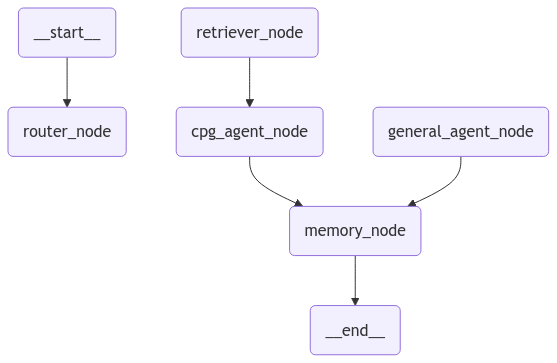

In [200]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langchain_core.messages import AIMessage, AIMessageChunk
# DEFINE THE GRAPH
cpg_workflow = StateGraph(AgentState)

# ADD THE NODES TO THE GRAPH
cpg_workflow.add_node("router_node", router_node) # ROUTE THE USER'S QUESTION TO THE MOST RELEVANT DATASOURCE
# retriever_node = ToolNode([retrieve_docs])
cpg_workflow.add_node("retriever_node", retrieve_docs) # RETRIEVER TOOL NODE
cpg_workflow.add_node("general_agent_node", general_cpg_agent_node) # GENERAL AGENT NODE TO GENERATE RESPONSE
cpg_workflow.add_node("cpg_agent_node", cpg_agent_node) # CPG AGENT NODE TO GENERATE RESPONSE BASED ON RETRIEVED DOCS
cpg_workflow.add_node("memory_node", write_memory) # MEMORY NODE TO WRITE MEMORY

# CONNECT THE NODES WITH EDGES
cpg_workflow.add_edge(START, "router_node") # START TO ROUTER NODE
cpg_workflow.add_edge("retriever_node", "cpg_agent_node")
cpg_workflow.add_edge("general_agent_node", "memory_node")
cpg_workflow.add_edge("cpg_agent_node", "memory_node")
cpg_workflow.add_edge("memory_node", END)

# DEFINE IN-MEMORY STORE FOR LONG TERM MEMORY
long_term_memory_store = InMemoryStore()

# DEFINE SHORT-TERM MEMORY STORE
short_term_memory_store = MemorySaver()

# COMPILE THE CPG GRAPH
cpg_graph = cpg_workflow.compile(checkpointer=short_term_memory_store, store=long_term_memory_store)

# VIEW THE CPG GRAPH
display(Image(cpg_graph.get_graph(xray=1).draw_mermaid_png()))


In [201]:
first_message = "Hello! I'm Bob, an Optometrist from the Philippines."
second_message = "I feel sad for the children in my environment. They tend to have poor vision probably due to long exposure to their devices."
third_message = "Do you remember my name?"
second_sample_query = "How should modifiable lifestyle risk factors like smoking and obesity be addressed in the periodic health examination for cardiovascular disease prevention?"
third_sample_query = "For adults and adolescents who screen positive for high-risk sexual behavior, what non-pharmacologic interventions for safe sex are recommended to prevent STIs and unintended pregnancies?"

In [207]:
# TEST THE CPG GRAPH
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# USER INPUT
input_message = HumanMessage(content="Wow! That's very informative. Thanks.")
first = True
# INVOKE THE GRAPH
# Stream LLM tokens for messages generated in nodes
async for msg, metadata in cpg_graph.astream(
    {"messages": [input_message]}, 
    config=config, 
    stream_mode="messages"
):
    if metadata.get("langgraph_node") in ['general_agent_node', 'cpg_agent_node']:
        if isinstance(msg, AIMessageChunk):
            if first:
                gathered = msg
                first = False
            else:
                gathered += msg
            
            print(msg.content, end='')


---CALLING THE ROUTER AGENT---
---ROUTING TO INTERNAL KNOWLEDGE---
---GENERAL CPG AGENT GENERATING RESPONSE---
It's my pleasure to assist you! I'm glad you found the previous information helpful. If you have any more questions or need further clarification on anything, feel free to ask. I'm here to help!---LENGTH OF MESSAGES: 4---
---MEMORY WRITER AGENT GENERATING RESPONSE---


In [203]:
current_messages_list = cpg_graph.get_state(config).values["messages"]

In [204]:
new_state = cpg_graph.get_state(config).values
new_state["messages"]

[HumanMessage(content='How should modifiable lifestyle risk factors like smoking and obesity be addressed in the periodic health examination for cardiovascular disease prevention?', additional_kwargs={}, response_metadata={}, id='15d3ae71-8e54-4839-aceb-0d5215644c81'),
 AIMessage(content='**Introduction**:\nAddressing modifiable lifestyle risk factors such as smoking and obesity is crucial in the periodic health examination for cardiovascular disease prevention.\n\n**Guideline-Based Answer**:\n- **Smoking**: Early identification and addressing of smoking as a risk factor can significantly reduce the burden of cardiovascular diseases. It is important to recognize the significance of screening individuals for cardiovascular diseases, especially those who are asymptomatic and apparently healthy.\n- **Obesity**: Along with smoking, obesity is another identified factor that can lead to cardiovascular death. Addressing obesity through lifestyle modifications is essential for reducing cardiov

In [187]:
current_messages_list

[HumanMessage(content='How should modifiable lifestyle risk factors like smoking and obesity be addressed in the periodic health examination for cardiovascular disease prevention?', additional_kwargs={}, response_metadata={}, id='5bcd30f1-e24e-4126-a669-a40e0b233028')]

In [213]:
history_messages = [message.content for message in cpg_graph.get_state(config).values["messages"]]
print('\n'.join(history_messages))

Yes! Especially right now, that more kids are spending more time with their phones.
That's a great point, Bob! As an optometrist in the Philippines, you must be seeing the impact of increased screen time on children's eye health. While I can't provide medical advice, it's generally recommended to encourage kids to take regular breaks from their screens and engage in outdoor activities. This can help reduce eye strain and promote overall well-being. Is there anything specific you'd like to know or discuss further?
What are the evidence-based recommendations for screening and early detection of vision disorders in asymptomatic children and adults, and how can I apply them in my practice?


In [210]:
# CHECK THE MEMORY STORE
check_namespace = ("memory", '1')
existing_memory = long_term_memory_store.get(check_namespace, "user_memory")
print(existing_memory.dict().get('value').get("memory"))

- **Name**: Not provided
- **Profession**: Not provided
- **Location**: Not provided
- **Summary**: The user inquired about addressing modifiable lifestyle risk factors like smoking and obesity in periodic health examinations for cardiovascular disease prevention and received guideline-based information on dietary recommendations and the importance of identifying risk factors.


In [ ]:
# BASEMODEL FOR ROUTING USER'S QUESTION
from pydantic import BaseModel, Field
from typing import Literal
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""
    context: Literal['internal_knowledge', 'base_knowledge', 'external_knowledge'] = Field(
        description="Given a user question choose to route it to internal_knowledge, base_knowledge, or external_knowledge",
    )

In [ ]:
# ROUTER AGENT
CPG_AGENT = ChatGroq(
    api_key=os.getenv("GROQ_API_KEY", ""),
    model="llama-3.3-70b-versatile",
    temperature=0.2,
)